In [1]:
import sys
sys.path.append("../src/")

import qa

%load_ext autoreload
%autoreload 2

# load dataset

In [2]:
import datasets
import pandas as pd
import matplotlib.pyplot as plt

DOMAIN = "movies"

/Users/spayot/miniforge3/envs/tfm7/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
domains = datasets.get_dataset_config_names("subjqa")
print("existing domains for subjqa:", domains, "\n")

assert DOMAIN in domains, f"{DOMAIN} this is not a valid domain name"
subjqa = datasets.load_dataset("subjqa", name=DOMAIN)
print(subjqa["train"]["answers"][1], "\n")

existing domains for subjqa: ['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor'] 



Found cached dataset subjqa (/Users/spayot/.cache/huggingface/datasets/subjqa/movies/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd)
100%|██████████| 3/3 [00:00<00:00, 397.24it/s]

{'text': [], 'answer_start': [], 'answer_subj_level': [], 'ans_subj_score': [], 'is_ans_subjective': []} 



## Exploratory Data Analysis

In [4]:
dfs = {split: dataset.to_pandas() for split, dataset in subjqa.flatten().items()}
def print_slices_size(dfs: dict[str, pd.DataFrame]) -> None:
    for split, df in dfs.items():
        print(f"Number of questions in {split + ':':<15} {df['id'].nunique():>10,}")

print_slices_size(dfs)

Number of questions in train:               1,369
Number of questions in test:                  291
Number of questions in validation:            261


In [5]:
qa_cols = ["title", "question", "answers.text", "answers.answer_start", "context"]
sample_df = dfs["train"].loc[:,qa_cols].sample(2)
sample_df

,title,question,answers.text,answers.answer_start,context
105,0792154649,How was the movie?,"[Great movie for the whole family, Great movie]","[19, 19]",I love this movie. Great movie for the whole f...
15,0780621964,Does this movie have good or rubbish effects?,[],[],I liked the first movie a lot so when the seco...


In [6]:
# how many items have answers?
dfs["train"]["answers.text"].apply(lambda x: len(x) > 0).value_counts()

False    856
True     513
Name: answers.text, dtype: int64

In [50]:
sample_df

,title,question,answers.text,answers.answer_start,context
105,0792154649,How was the movie?,"[Great movie for the whole family, Great movie]","[19, 19]",I love this movie. Great movie for the whole family. Charlton Heston is awes...
15,0780621964,Does this movie have good or rubbish effects?,[],[],I liked the first movie a lot so when the second one came out I went to see ...


In [61]:
idx = 0
start_idx = sample_df["answers.answer_start"].iloc[idx][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[idx][0])
sample_df["context"].iloc[idx][start_idx:end_idx], sample_df["answers.text"].iloc[idx][0]

('Great movie for the whole family', 'Great movie for the whole family')

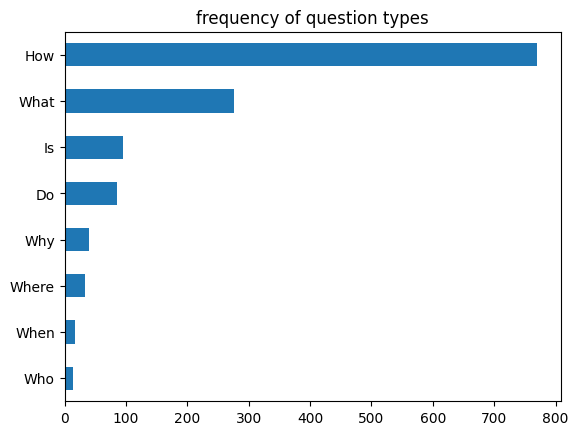

In [8]:
# what kind of questions are in the training set?
def count_start_words(series: pd.Series, start_words: list[str]) -> dict[str,int]:
    counts = {}
    for word in start_words:
        counts[word] = (series
            .str.lower()
            .str.startswith(word.lower())
            .sum())

    return counts

def plot_word_counts(word_counts: dict[str, int]) -> None:
    pd.Series(counts).sort_values().plot.barh(title="frequency of question types");

start_words = ["How", "What", "Where", "When", "Why", "Who", "Is", "Do"]
counts = count_start_words(dfs["train"]["question"], start_words)
plot_word_counts(counts)

In [9]:
def sample_questions_with_start_word(questions: pd.Series, start_word: str, sample_size: int = 3) -> pd.Series:
    return questions[questions.str.lower().str.startswith(start_word.lower())].sample(sample_size)

def print_samples_with_start_word_list(questions: pd.Series, start_word_list: list[str], sample_size: int = 3) -> None:
    for word in start_word_list:
        sample_questions = sample_questions_with_start_word(questions, word, sample_size)
        print(*sample_questions, sep="\n")
        print()


print_samples_with_start_word_list(dfs["train"]["question"], ["How", "What", "Is"])

How do you do for your beautiful messages?
How good is the story in this serie?
How is the bit?

What is your favorite movie?
What is the limit of the transfer?
What did you like most about the film?

Is the plot in the right place?
Is the main character a good actor?
Is it hard to find a way to reach them?



# Extracting answers from text

In [10]:
from transformers import AutoTokenizer

MODEL_CKPT = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

In [11]:
question = "Who plays the main character?"
context = "this film brilliantly directed by John Cameron shows a young carpenter (Merryll Streep) grow to fame in the midst of the 19th century."
inputs = tokenizer(question, context, return_tensors="pt")
print(inputs)
print(tokenizer.decode(inputs["input_ids"][0]))

{'input_ids': tensor([[  101,  2040,  3248,  1996,  2364,  2839,  1029,   102,  2023,  2143,
          8235,  2135,  2856,  2011,  2198,  7232,  3065,  1037,  2402, 10533,
          1006, 12831,  3363,  2358,  9910,  2361,  1007,  4982,  2000,  4476,
          1999,  1996, 12930,  1997,  1996,  3708,  2301,  1012,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
[CLS] who plays the main character? [SEP] this film brilliantly directed by john cameron shows a young carpenter ( merryll streep ) grow to fame in the midst of the 19th century. [SEP]


In [12]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(MODEL_CKPT)
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 2.1060, -5.7358, -6.0297, -5.5793, -6.0490, -6.5436, -6.5746,  2.1060,
         -4.6390, -6.0619, -5.8395, -6.4893, -6.0956, -6.2996, -5.0551, -6.3164,
         -5.6653, -1.2571, -2.6422,  0.8292,  3.0302,  6.6095, -2.4039, -2.4473,
         -5.3281, -1.3681, -4.4412, -5.5199, -5.8619, -6.3535, -5.9934, -3.9990,
         -6.2053, -6.0370, -4.9624, -6.0011, -6.7903, -5.9915,  2.1060]]), end_logits=tensor([[ 2.0439, -6.3125, -6.3776, -6.4139, -6.4673, -5.8300, -5.6640,  2.0439,
         -6.5273, -5.7469, -6.2036, -5.7139, -6.1205, -6.1102, -6.2016, -4.4481,
         -5.9626, -5.8089, -5.2867,  0.8968, -3.3977, -0.2626, -3.2219, -4.7237,
         -3.4788,  6.2356,  2.2657, -6.2941, -6.4426, -5.5345, -6.3411, -6.1913,
         -6.2336, -6.2938, -6.3297, -6.1236, -4.9332, -1.4371,  2.0439]]), hidden_states=None, attentions=None)


In [13]:
import transformers as tfm

In [14]:
pipe = tfm.pipeline(task="question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, top_k=3)

[{'score': 0.9206932187080383,
  'start': 72,
  'end': 86,
  'answer': 'Merryll Streep'},
 {'score': 0.0256821122020483,
  'start': 71,
  'end': 86,
  'answer': '(Merryll Streep'},
 {'score': 0.017378173768520355,
  'start': 72,
  'end': 87,
  'answer': 'Merryll Streep)'}]

# Haystack: Retriever-Reader architecture
## Document Store

In [18]:
from haystack.utils import launch_es

# launch elastic search docker container
launch_es()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Unable to find image 'elasticsearch:7.9.2' locally
7.9.2: Pulling from library/elasticsearch
9f74aa7d9ab9: Pulling fs layer
400a45e237b0: Pulling fs layer
da3333bd92b5: Pulling fs layer
8fcb044e3dce: Pulling fs layer
68c8ab10a68b: Pulling fs layer
f1a49ad5d099: Pulling fs layer
ce2c85c995ef: Pulling fs layer
bbfc9a234a20: Pulling fs layer
724bf09a020c: Pulling fs layer
8fcb044e3dce: Waiting
68c8ab10a68b: Waiting
f1a49ad5d099: Waiting
ce2c85c995ef: Waiting
bbfc9a234a20: Waiting
724bf09a020c: Waiting
400a45e237b0: Verifying Checksum
400a45e237b0: Download complete
8fcb044e3dce: Download complete
da3333bd92b5: Verifying Checksum
da3333bd92b5: Download complete
f1a49ad5d099: Verifying Checksum
f1a49ad5d099: Download complete
ce2c85c995ef: Verifying Checksum
ce2c85c995ef: Download complete
bbfc9a234a20: Verifying Checksum
bbfc9a234a20: Download complete
724bf09a020c: Download complete
9f74aa7d9ab9: Verifying Checksum
9f74aa7d9ab9: Download complete
9f74aa7d9ab9: Pull complete
400a45e237b0: 

cec8b1dca7c23e1e3bfa8ce5eb03998d6432a0c13312c579028bc34699635ce9


In [19]:
# verifying that elasticsearch cluster works
!curl -X GET "localhost:9200/?pretty"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
{
  "name" : "cec8b1dca7c2",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "PaaWLd4URPq9HqODjXe-Nw",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T04:28:49.179747Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [22]:
!curl -X GET "localhost:9200/_cat/indices"

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
yellow open movies 4ZW7kCudQja8SFzfVnGejw 1 1 0 0 208b 208b
yellow open label  9RFaY-AWRxWJIwQqspwxaw 1 1 0 0 208b 208b


**Note**: below cell has been extracted form haystack tutorial: https://haystack.deepset.ai/tutorials/01_basic_qa_pipeline

In [21]:
import os
from haystack.document_stores import ElasticsearchDocumentStore

# Get the host where Elasticsearch is running, default to localhost
host = os.environ.get("ELASTICSEARCH_HOST", "localhost")
document_store = ElasticsearchDocumentStore(host=host, username="", password="", index=DOMAIN, return_embedding=True)

In [83]:

def df_row_to_ES_doc(row, split: str) -> dict:
    return {
        "content": row.context, 
        "meta": {
            "item_id": row.title, 
            "question_id": row.id,
            "split": split,
        }}


def df_to_ES_doc(df: pd.DataFrame, split: str) -> list[dict]:
    return [
        df_row_to_ES_doc(row, split) 
        for row in df.drop_duplicates(subset="context").itertuples()
        ]

for split, df in dfs.items():
    docs = df_to_ES_doc(df, split)
    document_store.write_documents(docs, index=DOMAIN)

print(f"Loaded {document_store.get_document_count():,} documents")

# row = next(dfs["train"].itertuples())
# df_row_to_es_doc(row, "train")

# df_to_es_doc(dfs["train"].sample(3), "train")

Loaded 1,624 documents


# Retriever

In [85]:
from haystack.nodes import BM25Retriever

es_retriever = BM25Retriever(document_store=document_store)

In [107]:
item_id = "630575067X" # star wars episode 1
query = " who is the main character?"
retrieved_docs = es_retriever.retrieve(query=query, top_k=3, filters={"item_id": item_id, "split": "train"})
print(*retrieved_docs, sep='\n')

<Document: id=6a09e915e3af83102ab11bbc6527b4f3, content='1- Lacks a main character (no protagonist)2- Anakin is not introduced until 45 minutes into the movi...'>
<Document: id=2d0d8ad846456f58d2e68042b71e4398, content='Yes, my main gripe, like many fans of the franchise, is Jake Lloyd. But to surprise a few people, I ...'>
<Document: id=d450c78a3b8e7ae2c362299a99d5a58b, content='Get ready to be swept away by the next installment of one of the most loved and watched sci-fi movie...'>


# Reader

In [101]:
from haystack.nodes import FARMReader

# Load a  local model or any of the QA models on
# Hugging Face's model hub (https://huggingface.co/models)

MAX_SEQ_LENGTH, DOC_STRIDE = 384, 128
reader = FARMReader(model_name_or_path=MODEL_CKPT, 
    use_gpu=True, 
    progress_bar=False, 
    max_seq_len=MAX_SEQ_LENGTH,
    doc_stride=DOC_STRIDE,
    return_no_answer=True)


In [102]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'Who plays the main character?', 'no_ans_gap': 8.695183277130127, 'answers': [<Answer {'answer': 'Merryll Streep', 'type': 'extractive', 'score': 0.9352176189422607, 'context': 'this film brilliantly directed by John Cameron shows a young carpenter (Merryll Streep) grow to fame in the midst of the 19th century.', 'offsets_in_document': [{'start': 72, 'end': 86}], 'offsets_in_context': [{'start': 72, 'end': 86}], 'document_id': '9862efcec7c7cc3e2135f7fa86ee6601', 'meta': {}}>]}


## Pipeline

In [103]:
from haystack.pipelines import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)



In [114]:
TOP_K_READER = 3

item_id = "630575067X" # star wars episode 1
query = " how long is this movie?"

params = {
    "Retriever": {
        "top_k": 3,
        "filters": {
            "item_id": [item_id],
            "split": "train",
            }
        },
    "Reader": {
        "top_k": TOP_K_READER,
        },
    }
preds = pipe.run(query=query, params=params)

print(f"Question: {preds['query']}\n")
for idx in range(TOP_K_READER):
    print(f"Answer {idx + 1}: {preds['answers'][idx].answer}")
    print(f"Review snippet: ...{preds['answers'][idx].context}...\n\n")



Question:  how long is this movie?

Answer 1: 16 years
Review snipper: ...hey want; I just feel that they're judging The Phantom Menace based on 16 years of their own expectations rather than judging it for what it is: a vis...


Answer 2: 
Review snipper: ...None...


Answer 3: a huge disapointment
Review snipper: ...t this film would equal the Second Coming. However, the movie is a huge disapointment. Granted, the special effects  and ship and creature designs are...




# Improving QA Pipeline
## Evaluating Retriever

In [115]:
from haystack.pipelines import DocumentSearchPipeline

pipe = DocumentSearchPipeline(retriever=es_retriever)

### Generating labeled data for pipeline evaluation for test set

In [127]:
row

Pandas(Index=1, domain='movies', nn_mod='amazing', nn_asp='cinematography', query_mod='close', query_asp='relationship', q_reviews_id='5c47f7c54408b6fa6b388a3b3ac7689e', question_subj_level=1, ques_subj_score=0.0, is_ques_subjective=False, review_id='bb474a32c0035a8a75fd110c43cb3ed7', id='43e12e7953dc0eca200b658a0d0d1eb3', title='0310263662', context='I find it sad that reviewers such as "A Kid\'s Review" (only one of quite a few) found it necessary to use personal attacks as a way of conveying their lack of spiritual understanding of or enthusiasm for the film.  (Saying over and over again that they wish Mel had made another Mad Max film only shows they did not have the ability or desire to consider what the film was about.  You probably should not have seen it since you are clearly unable to grasp the truth of His message.)That said, I will not lower myself again to the same level as other reviewers who attack differing personal spiritual views as a means to criticize the film - I ca

In [142]:
from haystack import Label, Answer, Document

def create_label(row, answer: str, no_answer: bool):
    meta = {"item_id": row["title"], "question_id": row["id"]}
    return Label(
            query=row["question"], 
            answer=Answer(answer=answer), 
            origin="gold-label", 
            document=Document(
                content=row["context"], 
                id=row["review_id"]),
            meta=meta, 
            is_correct_answer=True, 
            is_correct_document=True,
            no_answer=no_answer, 
            filters={"item_id": [row["title"]], "split":["test"]}
            )


def create_labels_from_row(row) -> list[Label]:
    if len(row["answers.text"]) == 0:
        return [create_label(row, answer="", no_answer=True)]
    return [create_label(row, answer, no_answer=False) for answer in row["answers.text"]]
    
    

def create_labels_from_df(df: pd.DataFrame) -> list[Label]:
    labels = []
    for _, row in df.iterrows():
        labels += create_labels_from_row(row)

    return labels


# testing code
rows = dfs["test"].iterrows()
_, row = next(rows)
_, row = next(rows)

labels = create_labels_from_row(row)
assert len(labels) == 2


337

In [149]:
# execution code
labels = create_labels_from_df(dfs["test"])

document_store.write_labels(labels, index="label")

print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 337 question-answer pairs


In [150]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

273


In [159]:
labels_agg[0]

<MultiLabel: {'labels': [<Label: {'id': '8ef3bfc1-2164-4084-91c2-de61ff0d5049', 'query': 'What is your take on the direction the movie is taking?', 'document': {'id': 'e55d379edfcd04ec185b78106ecdb173', 'content': "This was in my opinion not a movie but an experience. Mel Gibson did such a great job of potraying the last hours of our Lord and Savior Jesus Christ's life. The movie was so moving and touching. I can't imagine having any of that done to me. Unfortunately, Jesus really didn't have a choice. That was foretold to happen to Jesus so we could be washed clean from our sins and have everlasting life.And to those who think that this movie was unrealistic in some respects you're right. It wasn't entirely realistc...because Jesus looked even worse then what they showed. In the Bible it clearly states that you couldn't even recognize Jesus that was how badly beaten he was.But, as to why no one helped him when he was being beaten or why he let them arrest him it was because it was for

In [160]:

# We can run the pipeline with the desired top_k value like this
eval_result = pipe.eval(
    labels=labels_agg,
    params={"Retriever": {"top_k": 3}},
)
metrics = eval_result.calculate_metrics()

print(f"Recall@3: {metrics['Retriever']['recall_single_hit']:.2f}")

Recall@3: 0.98


In [163]:
eval_result["Retriever"].head(3)

,multilabel_id,query,filters,context,gold_contexts,gold_id_match,context_match,answer_match,gold_id_or_answer_match,gold_id_and_answer_match,...,rank,document_id,gold_document_ids,gold_documents_id_match,gold_contexts_similarity,gold_answers_match,type,node,eval_mode,index
0,a3ecbb85a1f7497a9180023ca4656c5d,What is your take on the direction the movie is taking?,"b'{""item_id"": [""0310263662""], ""split"": [""test""]}'","I find it sad that reviewers such as ""A Kid's Review"" (only one of quite a f...",[],0.0,0.0,0.0,0.0,0.0,...,1.0,b964217f3614e4b573c7c1e058cc3032,[],[],[],[0.0],document,Retriever,integrated,0
1,a3ecbb85a1f7497a9180023ca4656c5d,What is your take on the direction the movie is taking?,"b'{""item_id"": [""0310263662""], ""split"": [""test""]}'","Now I am not a religious person, even tough I believe in the existence of a ...",[],0.0,0.0,0.0,0.0,0.0,...,2.0,45b427836e490b1e008e15b8c84560ab,[],[],[],[0.0],document,Retriever,integrated,1
2,a3ecbb85a1f7497a9180023ca4656c5d,What is your take on the direction the movie is taking?,"b'{""item_id"": [""0310263662""], ""split"": [""test""]}'",This was in my opinion not a movie but an experience. Mel Gibson did such a ...,[],0.0,0.0,0.0,0.0,0.0,...,3.0,be832bea3625db1ba345826e781f6916,[],[],[],[0.0],document,Retriever,integrated,2


In [166]:
import haystack as hs

In [174]:
def evaluate_retriever_recall(retriever: hs.nodes.BaseRetriever, top_ks: list[int]= [1,3,5,10,20]) -> pd.DataFrame:
    pipe = DocumentSearchPipeline(retriever)
    eval_results = pipe.eval(
        labels=labels_agg, 
        params={"Retriever": {"top_k": max(top_ks)}})
    
    results = {}
    for k in top_ks:
        metrics = eval_results.calculate_metrics(simulated_top_k_retriever=k)
        results[k] = {"recall": metrics["Retriever"]["recall_single_hit"]}
    return pd.DataFrame.from_dict(results, orient="index")

bm25_results = evaluate_retriever_recall(es_retriever)


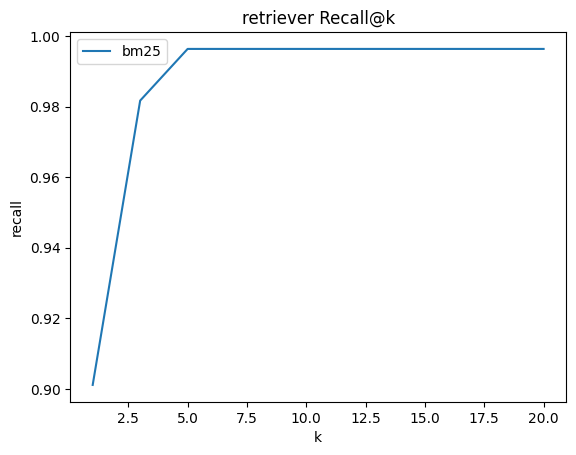

In [178]:
def plot_retriever_eval(results: dict[str, pd.DataFrame], metrics: str = "recall") -> None:
    fig, ax = plt.subplots()
    for retriever_name, results_df in results.items():
        results_df.plot(y=metrics, ax=ax, label=retriever_name)
    plt.title("retriever Recall@k")
    plt.xlabel("k")
    plt.ylabel(metrics)
    plt.show()

retriever_results = {"bm25": bm25_results}

plot_retriever_eval(retriever_results)



## Comparing with DPR retriever

In [179]:
from haystack.nodes import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 12.6kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 587kB/s] 
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 962kB/s] 
Downloading: 100%|██████████| 493/493 [00:00<00:00, 161kB/s]
Downloading: 100%|██████████| 438M/438M [01:28<00:00, 4.93MB/s] 
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 9.15kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 863kB/s] 
Downloading: 100%|██████████| 466k/466k [00:00<00:00, 953kB/s] 
Downloading: 100%|██████████| 492/492 [00:00<00:00, 218kB/s]
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokenizerFast'.
Downloading: 100%|██████████| 438M/438M [01:05<00:00, 6.70MB/s] 


In [180]:
document_store.update_embeddings(retriever=dpr_retriever)

Updating embeddings: 10000 Docs [02:04, 80.44 Docs/s]           


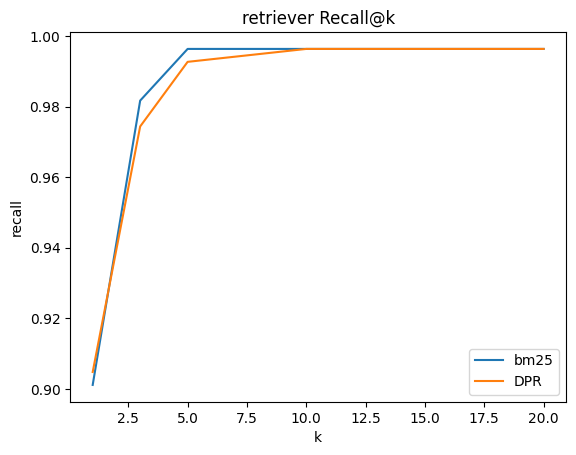

In [181]:
retriever_results["DPR"] = evaluate_retriever_recall(dpr_retriever)

plot_retriever_eval(retriever_results)

## Evaluating Reader

In [184]:
from haystack.modeling.evaluation.squad import compute_f1, compute_exact

def print_reading_metrics(pred, label) -> None:
    print(f"label:      {label}")
    print(f"prediction: {pred}")
    print(f"\tEM: {compute_exact(label, pred)}")
    print(f"\tF1: {compute_f1(label, pred)}")

print_reading_metrics(pred = "about 6000 hours", label = "6000 hours")
print_reading_metrics(f"about 6000 dollars", "6000 hours")

label:      6000 hours
prediction: about 6000 hours
	EM: 0
	F1: 0.8
label:      6000 hours
prediction: about 6000 dollars
	EM: 0
	F1: 0.4


In [187]:
def evaluate_reader(reader, score_keys: list[str] = None) -> dict:
    if score_keys is None:
        score_keys = ['exact_match', 'f1']
    
    pipe = hs.pipelines.Pipeline()
    pipe.add_node(component=reader, name="Reader", inputs=["Query"])
    docs = [[label.document for label in multilabel.labels] for multilabel in labels_agg]
    eval_result = pipe.eval(
        labels=labels_agg,
        documents=docs,
        params={}
        )
    metrics = eval_result.calculate_metrics(simulated_top_k_reader=1)
    return {k: v for k, v in metrics["Reader"].items() if k in score_keys}



reader_eval = {}
reader_eval["MiniLM. Fine-tuned on SQUAD"] = evaluate_reader(reader)

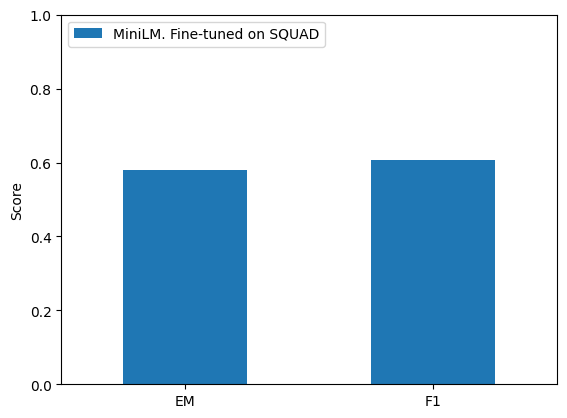

In [189]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval).reindex(["exact_match", "f1"])
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    ax.set_ylim([0,1])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

## Domain Adaptation
Requires to transform training data into SQUAD JSON format

In [202]:
sample_df = dfs["train"].loc[:, ["context", "title", "answers.text", "answers.answer_start", "id", "review_id"]].sample(3)
sample_df

,context,title,answers.text,answers.answer_start,id,review_id
822,The negative reviews about crash is mostly non-sense. Crash is one of the be...,B000A3XY5A,"[the film dealt with that truth very well, the best films produced by Hollyw...","[492, 70]",67048a32543bc9a01f67e99017addc09,c61736d71be1632ce96d64c32e353ab9
150,"Episode IV - A New HopeSpecs and Features125 mins, PG, letterboxed widescree...",0793906091,[],[],d93d50a4575c566715daba1e0c7e63ff,48a13ede23976e6a6bfb90dc1efdc633
274,I know alot of Halloween fans were disappointed with this box set because th...,6304697961,[],[],a9c80950950a22590c92e391c2ae706a,0cc6c3ae8072a7fa5ab92720a73286ac


In [203]:
_, row = next(sample_df.iterrows())
row

context                 The negative reviews about crash is mostly non-sense. Crash is one of the be...
title                                                                                        B000A3XY5A
answers.text            [the film dealt with that truth very well, the best films produced by Hollyw...
answers.answer_start                                                                          [492, 70]
id                                                                     67048a32543bc9a01f67e99017addc09
review_id                                                              c61736d71be1632ce96d64c32e353ab9
Name: 822, dtype: object

In [204]:


def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

[{'text': 'the film dealt with that truth very well', 'answer_start': 492}, {'text': 'the best films produced by Hollywood', 'answer_start': 70}]


In [222]:

title = "B000A3XY5A"
qa.processing.create_all_paragraphs_per_title(dfs["train"].query(f"title=='{title}'"))

[{'context': "The negative reviews about crash is mostly non-sense. Crash is one of the best films produced by Hollywood in the last 10 years. I just viewed it for the second time and the movie still felt very intense. The message is simple and clear. No one can judge another human being. Everyone has good and bad. Both qualities will be shown throughout one's life. And racism is so much more than color of our skin. The movie shows that even a mother can be a racist toward her own children. I thought the film dealt with that truth very well. If a person watches this film and learns nothing or feels nothing, that is pretty sad.",
  'qas': [{'question': 'How was film ?',
    'id': '67048a32543bc9a01f67e99017addc09',
    'answers': [{'text': 'the film dealt with that truth very well',
      'answer_start': 492},
     {'text': 'the best films produced by Hollywood', 'answer_start': 70}]}]},
 {'context': 'Being, myself, a person born and raised in the San Fernando Valley of Los Angeles (whe

In [220]:
import json

def create_all_paragraphs_per_title(df_by_title: pd.DataFrame):
    review_ids = df_by_title.review_id.unique()
    return [
        create_paragraph(df_by_title.query(f"review_id=='{review_id}'")) 
        for review_id in review_ids
        ]
        

def create_paragraph(df: pd.DataFrame) -> dict:
    paragraph = {
        "context": df.context.iloc[0], # all rows should have same context
        "qas": [create_qas(row) for _, row in df.iterrows()]}
    return paragraph

def create_qas(row):
    return {
        "question": row["question"],
        "id": row["id"],
        "answers": create_answers_from_row(row),
    }

def create_answers_from_row(row) -> dict:
    if len(row["answers.text"]) == 0:
        return []
    return [{
        "text": text, 
        "answer_start": start}
        for text, start in zip(row["answers.text"], row["answers.answer_start"])
        ]


title = "B000A3XY5A"
create_all_paragraphs_per_title(dfs["train"].query(f"title=='{title}'"))

[{'context': "The negative reviews about crash is mostly non-sense. Crash is one of the best films produced by Hollywood in the last 10 years. I just viewed it for the second time and the movie still felt very intense. The message is simple and clear. No one can judge another human being. Everyone has good and bad. Both qualities will be shown throughout one's life. And racism is so much more than color of our skin. The movie shows that even a mother can be a racist toward her own children. I thought the film dealt with that truth very well. If a person watches this film and learns nothing or feels nothing, that is pretty sad.",
  'qas': [{'question': 'How was film ?',
    'id': '67048a32543bc9a01f67e99017addc09',
    'answers': [{'text': 'the film dealt with that truth very well',
      'answer_start': 492},
     {'text': 'the best films produced by Hollywood', 'answer_start': 70}]}]},
 {'context': 'Being, myself, a person born and raised in the San Fernando Valley of Los Angeles (whe

In [223]:

groups = (
    dfs["test"]
    .groupby("title")
    .apply(create_all_paragraphs_per_title)
    .to_frame(name="paragraphs")
    .reset_index())

'../data/transformed/movies-{split}.json'

In [239]:
qa.squad_conversion.convert_all_data_to_squad(dfs, f"../data/transformed/{DOMAIN}-{{split}}.json")

AttributeError: module 'qa' has no attribute 'squad_conversion'

In [233]:
df.title.isnull().sum()

0

In [235]:
sum(1 for title in subjqa["data"] for paragraph in title["paragraphs"])

289

In [217]:
dfs["train"].sample(1).T

,38
domain,movies
nn_mod,funny
nn_asp,situation
query_mod,funny
query_asp,plot
q_reviews_id,871ea2b0604fc68b9c42a936eafe581d
question_subj_level,1
ques_subj_score,0.0
is_ques_subjective,False
review_id,33c9eea3d10947175123293ed05de890
